In [375]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import rc
import matplotlib.ticker as ticker
from matplotlib import rc
from scipy.stats import norm
from scipy.special import factorial
from scipy.special import gammaln
from tqdm import tqdm
import scipy.optimize as spo

In [376]:
# Matplotlib customize
plt.rcParams['figure.figsize'] = [6,5]
plt.rcParams['figure.dpi'] = 100

plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 20

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 4

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.markerscale'] = 1.5
plt.rcParams['legend.borderpad'] = 0.6
plt.rcParams['legend.framealpha'] = 0.7

In [377]:
# Reading channels
data = pd.read_csv('datos.csv',sep=',')
n = np.array(data.n)
b = np.array(data.b)
s = np.array(data.s)
N = n.shape[0]
data

,n,b,s
0,105,100,10
1,70,67,20


In [378]:
def LogLikelihood(mu,n,b,s):
    
    lambda_ = mu*s + b
    
    log_likelihood = -lambda_ + n * np.log(lambda_) - gammaln(n+1)
    
    return log_likelihood

In [379]:
def GetJointLogLikelihood(mu,n,b,s):
    
    JointLog = 0.
    
    for c in range(N):
        JointLog += LogLikelihood(mu,n[c],b[c],s[c])
            
    return -JointLog

In [380]:
mu = np.linspace(0.,2.,20)
LogLike = GetJointLogLikelihood(mu,n,b,s)

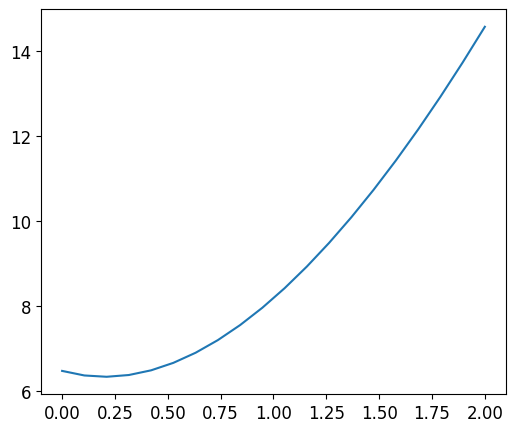

In [381]:
plt.plot(mu,LogLike)

In [382]:
# Minimizando el log-likelihood
mu0 = 1.
result = spo.minimize( GetJointLogLikelihood, mu0, args=(n,b,s), options={"disp":True}, method='Nelder-Mead' )

muhat = 0.
if result.success:
    print('Maximum found')
    muhat = result.x[0]
else:
    print('Maximum no found - SETPOI')

Optimization terminated successfully.
         Current function value: 6.341844
         Iterations: 16
         Function evaluations: 32
Maximum found


In [383]:
muhat

0.2018554687499993

In [384]:
def GetqmObs(mu,n,b,s):

    mu0 = 1.
    result = spo.minimize( GetJointLogLikelihood, mu0, args=(n,b,s), options={"disp":False}, method='Nelder-Mead' )
    
    muhat = result.x[0]
    
    qm = 0.
    
    for c in range(N):
        
        if mu > muhat:
            qm += -2*(LogLikelihood(mu,n[c],b[c],s[c]) - LogLikelihood(muhat,n[c],b[c],s[c]))
        else:
            qm += 0.
            
    return qm

In [385]:
qmObs = GetqmObs(1.4,n,b,s)
qmObs

7.875058116136415

In [386]:
# Expected
qmObsE = GetqmObs(1.4,b,b,s)
qmObsE

11.003655042635955

In [387]:
def Getqm(mu,Null=True):
    
    Ntoys = np.zeros(N)
   
    for c in range(N):
        
        if Null:
            ntoy = np.random.poisson(b[c])
        else:
            ntoy = np.random.poisson(mu*s[c]+b[c])
          
        Ntoys[c] = ntoy
            
    return GetqmObs(mu,Ntoys,b,s)

In [388]:
def Sampler(mu,Ntoys = int(1e3)):
    
    q0 = np.zeros(Ntoys)
    q1 = np.zeros(Ntoys)
    
    for i in tqdm(range(Ntoys)):
        q0[i] = Getqm(mu,Null=True)
        q1[i] = Getqm(mu,Null=False)
        
    return q0,q1

In [399]:
q0,q1 = Sampler(1.1)

100%|████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 166.62it/s]


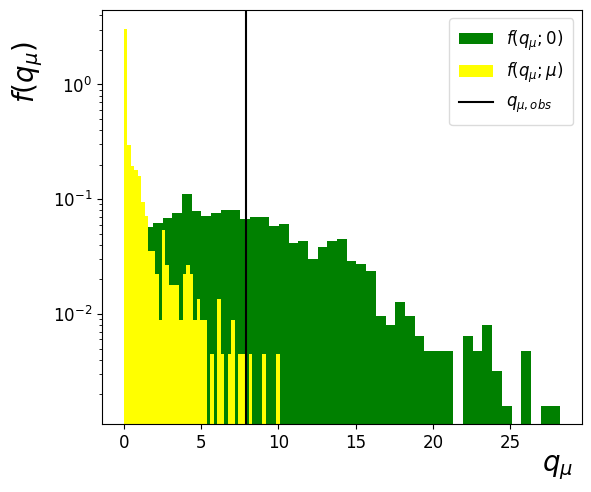

In [403]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(q0,bins=45,color='green',density=True,label=r'$f(q_{\mu};0)$')
ax.hist(q1,bins=45,color='yellow',density=True,label=r'$f(q_{\mu};\mu)$')
ax.axvline(x=qmObs,color='k',label=r'$q_{\mu,obs}$')

# Label X
ax.set_xlabel(r'$q_{\mu}$')
ax.xaxis.set_label_coords(0.95,-0.07)

# Label Y
ax.set_ylabel(r'$f(q_{\mu})$')
ax.yaxis.set_label_coords(-0.12,0.85)

ax.set_yscale('log')

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('Distribution_qm.pdf')

In [401]:
def GetPValue(data,Qobs):

    count_above_threshold = np.sum( data >= Qobs )
    p_value = count_above_threshold / data.shape[0]

    return p_value

In [402]:
GetPValue(q1,qmObs)

0.003

In [393]:
# p-value scan 
def GetCls(mu,Expected = False):
    
    p_value = np.zeros_like(mu)
    
    for i in range(mu.shape[0]):
        
        if Expected:
            qmObs = GetqmObs(mu[i],b,b,s)
        else:
            qmObs = GetqmObs(mu[i],n,b,s)
            
        q0,q1 = Sampler(mu[i])
            
        p0 = GetPValue(q0,qmObs)
        p1 = GetPValue(q1,qmObs)
        
        if p0 != 0:
            Cls = p1/p0
        else:
            print('Problemas con la hipotesis nula')
            Cls = p1
        
        p_value[i] = Cls
        
    return p_value

In [394]:
mu = np.linspace(0,1.5,8)
Op_value = GetCls(mu)
Ep_value = GetCls(mu,Expected=True)

100%|████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 162.52it/s]


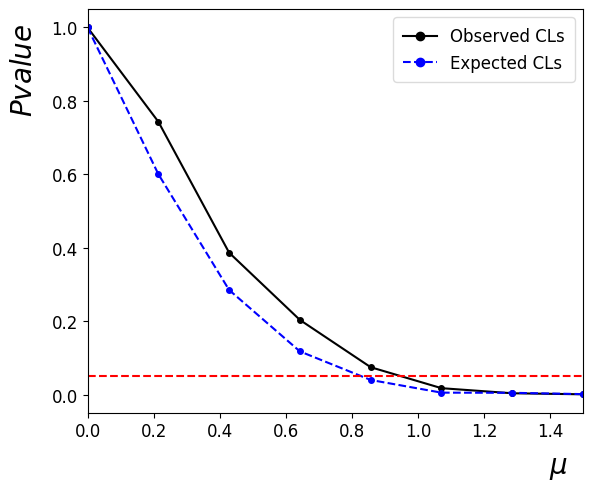

In [395]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(mu,Op_value,color='k',marker='o',label='Observed CLs')
ax.plot(mu,Ep_value,'--',color='b',marker='o',label='Expected CLs')
ax.axhline(y=0.05,ls='--',color='r')

# Label X
ax.set_xlabel(r'$\mu$')
ax.xaxis.set_label_coords(0.95,-0.1)
ax.set_xlim(mu[0],mu[-1])

# Label Y
ax.set_ylabel(r'$Pvalue$')
ax.yaxis.set_label_coords(-0.1,0.85)

# Ajustar los márgenes automáticamente
plt.tight_layout()

#Legend
ax.legend(loc='upper right',bbox_to_anchor=(1,1),ncol=1,title='')

#
plt.savefig('UpperLimit_qmScan.pdf')

In [396]:
# Upper limit
def GetUpperLimit(mu,Cls,alpha = 0.05):

    i = np.where( Cls <= alpha )

    if len(i[0]) == 0:
        print('--- Cls is never less than alpha --- ')
        return 0.
    else:
        i = i[0][0]

    # Saving the indez where pvalues is less than the critical value

    x0 = mu[i-1]
    x1 = mu[i]
    fx0 = Cls[i-1]
    fx1 = Cls[i]

    # Compute the slope
    m = (fx1-fx0)/(x1-x0)

    if m == 0:
        print('--- Problem with the scan ---')
        return 0.

    # 1D Polynomial interpolation
    mup = (alpha - fx0)/m + x0

    return mup

In [397]:
ExpectedLimit = GetUpperLimit(mu,Ep_value)
ExpectedLimit

0.8309146490937143

In [398]:
ObservedLimit = GetUpperLimit(mu,Op_value)
ObservedLimit

0.9517840126793978